# Airline Sentiment Analysis

## Package Installation & Imports

In [5]:
#! pip install --upgrade pip

In [89]:
# ! pip install pandas matplotlib openai

In [124]:
# Standard python imports
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn
#import seaborn as sns

# For API calls & experimentation runs
import openai
import os # ENV Variables
import json
import time

# For function declarations
from typing import List, Dict, Callable

## 1. Data Loading

In [28]:
# Load train/test datasets
train_df = pd.read_csv("data/airline_train_sentiment.csv")
test_df = pd.read_csv("data/airline_test_sentiment.csv")

In [31]:
# Basic info
print(f"Training set: {len(train_df)} tweets")
print(f"Test set: {len(test_df)} tweets")
print(f"Columns: {train_df.columns.tolist()}")

Training set: 900 tweets
Test set: 300 tweets
Columns: ['tweet', 'airlines', 'sentiment']


## 2. Exploratory Data Analysis

In [59]:
def parse_airlines(airline_str):
    """Parse the string representation of airline lists"""
    try:
        # Remove brackets and quotes, then split
        cleaned = airline_str.replace('[', '').replace(']', '').replace("'", "").strip()
        if cleaned:
            return [airline.strip() for airline in cleaned.split(',') if airline.strip()]
        return []
    except:
        return []

In [60]:
# Process both datasets
for df in [train_df, test_df]:
    df['airlines_list'] = df['airlines'].apply(parse_airlines)
    df['tweet_length'] = df['tweet'].str.len()
    df['word_count'] = df['tweet'].str.split().str.len()
    df['num_airlines'] = df['airlines_list'].str.len()
    df['dataset'] = 'train' if df is train_df else 'test'

# Combine datasets
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [62]:
print(f"=== DATASET OVERVIEW ===")
print(f"- Training set: {len(train_df)} tweets")
print(f"- Test set: {len(test_df)} tweets") 
print(f"- Total: {len(combined_df)} tweets")
print(f"- Columns: {list(combined_df.columns)}")

# Data Quality Summary
print(f"\n=== DATA QUALITY SUMMARY ===")
multiple_airlines = len(combined_df[combined_df['num_airlines'] > 1])
print(f"Tweets with multiple airlines: {multiple_airlines} ({multiple_airlines/len(combined_df)*100:.1f}%)")
print(f"Missing data: {combined_df.isnull().sum().sum()} total missing values")
print(f"Sentiment categories: {sorted(combined_df['sentiment'].unique())}")

=== DATASET OVERVIEW ===
- Training set: 900 tweets
- Test set: 300 tweets
- Total: 1200 tweets
- Columns: ['tweet', 'airlines', 'sentiment', 'airlines_list', 'tweet_length', 'num_airlines', 'word_count', 'dataset']

=== DATA QUALITY SUMMARY ===
Tweets with multiple airlines: 37 (3.1%)
Missing data: 0 total missing values
Sentiment categories: ['negative', 'neutral', 'positive']


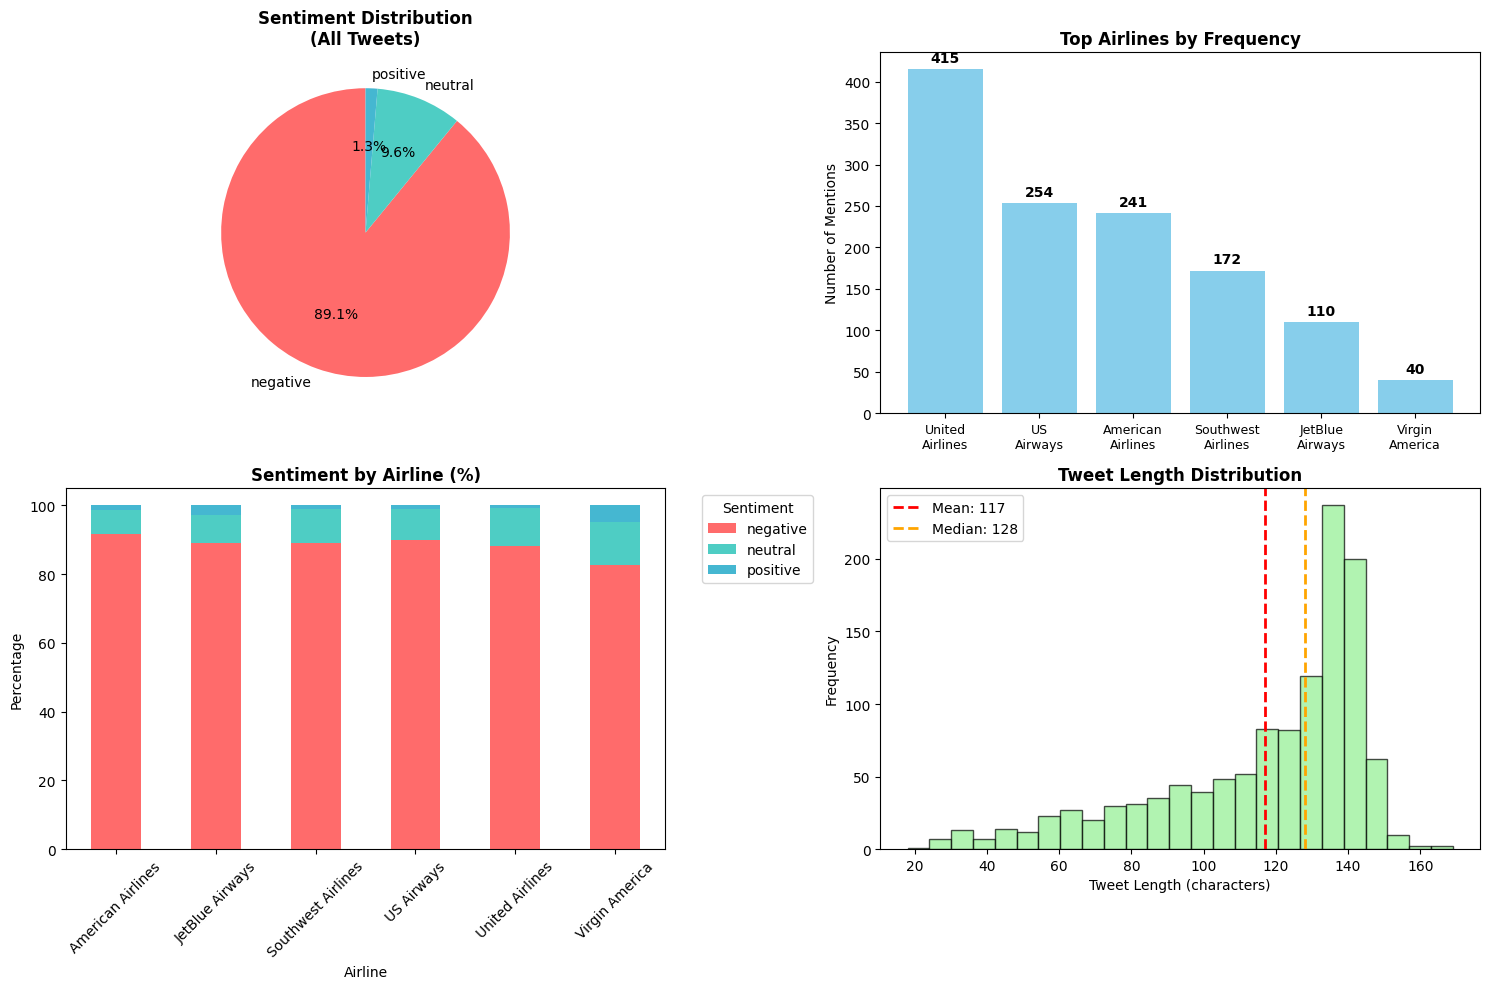

In [85]:
# Create 4 key visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Sentiment Distribution
ax1 = axes[0, 0]
sentiment_counts = combined_df['sentiment'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = ax1.pie(sentiment_counts.values, 
                                   labels=sentiment_counts.index, 
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax1.set_title('Sentiment Distribution\n(All Tweets)', fontweight='bold', fontsize=12)

# 2. Airline Frequency  
ax2 = axes[0, 1]
# Get all airline mentions
all_airlines = []
for airlines_list in combined_df['airlines_list']:
    all_airlines.extend(airlines_list)
airline_counts = pd.Series(all_airlines).value_counts()

# Plot top 6 airlines
top_airlines = airline_counts.head(6)
bars = ax2.bar(range(len(top_airlines)), top_airlines.values, color='skyblue')
ax2.set_xticks(range(len(top_airlines)))
ax2.set_xticklabels([name.replace(' ', '\n') for name in top_airlines.index], 
                    rotation=0, ha='center', fontsize=9)
ax2.set_ylabel('Number of Mentions')
ax2.set_title('Top Airlines by Frequency', fontweight='bold', fontsize=12)

# Add value labels
for bar, value in zip(bars, top_airlines.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(value), ha='center', va='bottom', fontweight='bold')

# 3. Sentiment by Top Airlines
ax3 = axes[1, 0]
# Create sentiment matrix for top 6 airlines (all 6 main airlines)
top_5_airlines = airline_counts.head(6).index
airline_sentiment_data = []

for _, row in combined_df.iterrows():
    for airline in row['airlines_list']:
        if airline in top_5_airlines:
            airline_sentiment_data.append({
                'airline': airline, 
                'sentiment': row['sentiment']
            })

if airline_sentiment_data:
    sentiment_df = pd.DataFrame(airline_sentiment_data)
    sentiment_matrix = sentiment_df.groupby(['airline', 'sentiment']).size().unstack(fill_value=0)
    # Convert to percentages
    sentiment_pct = sentiment_matrix.div(sentiment_matrix.sum(axis=1), axis=0) * 100
    
    # Create stacked bar chart
    sentiment_pct.plot(kind='bar', stacked=True, ax=ax3, 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax3.set_title('Sentiment by Airline (%)', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Airline')
    ax3.set_ylabel('Percentage')
    ax3.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=45)

# 4. Tweet Length Distribution
ax4 = axes[1, 1]
ax4.hist(combined_df['tweet_length'], bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
mean_length = combined_df['tweet_length'].mean()
median_length = combined_df['tweet_length'].median()

ax4.axvline(mean_length, color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mean_length:.0f}')
ax4.axvline(median_length, color='orange', linestyle='--', linewidth=2,
           label=f'Median: {median_length:.0f}')

ax4.set_xlabel('Tweet Length (characters)')
ax4.set_ylabel('Frequency')
ax4.set_title('Tweet Length Distribution', fontweight='bold', fontsize=12)
ax4.legend()

plt.tight_layout()
plt.show()

In [86]:
# Print key insights for prompt engineering
print("\n" + "="*50)
print("KEY INSIGHTS FOR PROMPT ENGINEERING")
print("="*50)

print(f"\n=== AIRLINE PATTERNS ===")
print(f"• {len(airline_counts)} unique airlines in dataset")
print(f"• Top 3: {', '.join(airline_counts.head(3).index.tolist())}")
print(f"• {multiple_airlines} tweets mention multiple airlines (edge case for extraction)")
print(f"• United garners the most negative tweets by %, while Virgin America and Jet Blue garner the most positive tweets by %")

print(f"\n=== SENTIMENT PATTERNS ===")
for sentiment, count in sentiment_counts.items():
    pct = (count / len(combined_df)) * 100
    print(f"• {sentiment.capitalize()}: {count} tweets ({pct:.1f}%)")

print(f"\n=== TWEET CHARACTERISTICS ===")
print(f"• Average length: {combined_df['tweet_length'].mean():.0f} characters")
print(f"• Range: {combined_df['tweet_length'].min()}-{combined_df['tweet_length'].max()} characters")
print(f"• Most tweets are single airline mentions ({len(combined_df)-multiple_airlines} out of {len(combined_df)})")

print(f"\n=== PROMPT ENGINEERING IMPLICATIONS ===")
print(f"• Focus on single airline extraction (96.9% of cases)")
print(f"• Handle airline name variations (formal names vs. abbreviations)")
print(f"• Extraction model should handle variations such as capitalizations, concatentation, mentions, spelling errors")
print(f"• Negative sentiment dominates - model should be good at detecting complaints")
print(f"• Tweet length varies widely - prompts should work across different lengths")

# Sample challenging cases for prompt development
print(f"\n=== SAMPLE CHALLENGING CASES ===")
multi_airline_samples = combined_df[combined_df['num_airlines'] > 1].head(3)
for i, (_, row) in enumerate(multi_airline_samples.iterrows(), 1):
    print(f"\nExample {i} (Multiple airlines):")
    print(f"Airlines: {row['airlines_list']}")
    print(f"Tweet: \"{row['tweet'][:100]}...\"")
    print(f"Sentiment: {row['sentiment']}")

# Show variety in airline mentions
print(f"\n=== AIRLINE NAME VARIATIONS TO HANDLE ===")
variations = {
    'American Airlines': ['American', '@AmericanAir', 'AA', 'AmericanAir', 'American Air'],
    'United Airlines': ['United', '@United', 'UA', 'UnitedAir', 'United Air', 'united'], 
    'Southwest Airlines': ['Southwest', '@SouthwestAir', 'SWA', 'SouthwestAir', 'Southwest Air'],
    'US Airways': ['US Airways', '@USAirways', 'US Air', 'USAir', 'USAirways'],
    'JetBlue Airways': ['JetBlue', '@JetBlue', 'Jet Blue', 'jetblue', 'JETBLUE', 'JetBlue Airways'],
    'Virgin America': ['Virgin', '@VirginAmerica', 'VA', 'Virgin America', 'VirginAmerica'],
    #'Delta Air Lines': ['Delta', '@Delta', 'DL', 'Delta Air', 'Delta Airlines'],
    #'Air Canada': ['Air Canada', '@AirCanada', 'AirCanada', 'AC']
}

for airline, vars in variations.items():
    print(f"• {airline}: {', '.join(vars)}")

print(f"\n=== OTHER THOUGHTS ===")
print(f"• Only one test case with no airline: Jetblue marked as ''; can consider that some test cases are not correct.")
print(f"• Consider prompting model to take spelling errors into account for entity extraction")
print(f"• The 'subject' airline is almost always the first word; other mentioned airlines are typically used as a positive comparison")
print(f"• Tweeks are likely skewed negative given consumer inclination to mention an airline when there's an issue")


KEY INSIGHTS FOR PROMPT ENGINEERING

=== AIRLINE PATTERNS ===
• 8 unique airlines in dataset
• Top 3: United Airlines, US Airways, American Airlines
• 37 tweets mention multiple airlines (edge case for extraction)
• United garners the most negative tweets by %, while Virgin America and Jet Blue garner the most positive tweets by %

=== SENTIMENT PATTERNS ===
• Negative: 1069 tweets (89.1%)
• Neutral: 115 tweets (9.6%)
• Positive: 16 tweets (1.3%)

=== TWEET CHARACTERISTICS ===
• Average length: 117 characters
• Range: 18-169 characters
• Most tweets are single airline mentions (1163 out of 1200)

=== PROMPT ENGINEERING IMPLICATIONS ===
• Focus on single airline extraction (96.9% of cases)
• Handle airline name variations (formal names vs. abbreviations)
• Extraction model should handle variations such as capitalizations, concatentation, mentions, spelling errors
• Negative sentiment dominates - model should be good at detecting complaints
• Tweet length varies widely - prompts should 

## 3. Prompt Engineering & Testing

In [180]:
# Initialize OpenAI client
os.environ["OPENAI_API_KEY"] = "<ADD KEY BEFORE RUNNING>"
MODEL = "gpt-4o-mini"
client = openai.OpenAI()

In [181]:
print("=== SIMPLE BASELINE EXPERIMENTS ===")
print(f"Model: {MODEL}")
print("Testing 3 approaches on 30 samples")

=== SIMPLE BASELINE EXPERIMENTS ===
Model: gpt-4o-mini
Testing 3 approaches on 30 samples


In [135]:
# =============================================================================
# BASE PROMPTS
# =============================================================================

def prompt_entity_v1(tweet: str) -> str:
    """Simple entity extraction prompt"""
    return f"""Extract all airline names mentioned in this tweet.

Tweet: "{tweet}"

Return as JSON: {{"airlines": ["Airline Name 1", "Airline Name 2"]}}
If no airlines mentioned, return: {{"airlines": []}}"""

def sentiment_prompt_v1_basic(tweet: str, airline: str) -> str:
    """Basic sentiment analysis prompt"""
    return f"""What is the sentiment of this tweet toward {airline}?

Tweet: "{tweet}"
Airline: {airline}

Return as JSON: {{"sentiment": "positive"}} or {{"sentiment": "negative"}} or {{"sentiment": "neutral"}}"""

In [136]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def call_api(prompt: str, max_tokens: int = 150) -> str:
    """Make API call with error handling"""
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=max_tokens
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API Error: {e}")
        return ""

def parse_entity_response_clean(response: str) -> List[str]:
    """Clean JSON parsing without normalization"""
    try:
        # Remove markdown code block formatting if present
        if response.startswith('```'):
            lines = response.split('\n')
            json_lines = [line for line in lines if line.strip() and not line.strip().startswith('```')]
            if json_lines:
                response = '\n'.join(json_lines)
        
        # Parse JSON
        data = json.loads(response)
        airlines = data.get("airlines", [])
        
        # Handle case where airlines might be a string
        if isinstance(airlines, str):
            airlines = [airlines]
            
        return airlines
        
    except json.JSONDecodeError:
        print(f"JSON Parse Error: {response[:50]}...")
        return []

def parse_sentiment_response(response: str) -> str:
    """Parse sentiment analysis response"""
    try:
        # Remove markdown code block formatting if present
        if response.startswith('```'):
            lines = response.split('\n')
            json_lines = [line for line in lines if line.strip() and not line.strip().startswith('```')]
            if json_lines:
                response = '\n'.join(json_lines)
        
        # Try to parse JSON
        data = json.loads(response)
        sentiment = data.get("sentiment", "").lower().strip()
        
        # Validate sentiment
        if sentiment in ["positive", "negative", "neutral"]:
            return sentiment
        else:
            print(f"Invalid sentiment in JSON: {sentiment}")
            return "unknown"
            
    except json.JSONDecodeError:
        # Fallback: look for sentiment keywords in response
        response_lower = response.lower().strip()
        
        if "positive" in response_lower:
            return "positive"
        elif "negative" in response_lower:
            return "negative"
        elif "neutral" in response_lower:
            return "neutral"
        else:
            print(f"Could not parse sentiment from: {response[:50]}...")
            return "unknown"

### Entity Extraction Experiments

In [137]:
# =============================================================================
# EXPERIMENT 1: ENTITY EXTRACTION RUNNER
# =============================================================================

def run_prompt_experiment(
    prompt_func: Callable[[str], str],
    prompt_name: str,
    n_samples: int = 30
) -> Dict:
    """Run entity extraction experiment with specific prompt"""
    
    print(f"\n🔍 PROMPT EXPERIMENT: {prompt_name} ({n_samples} samples)")
    print("-" * 60)
    
    # Get sample data (same sample for consistency)
    sample_df = combined_df.sample(n=n_samples, random_state=42)
    
    results = []
    correct = 0
    total = 0
    
    for idx, row in sample_df.iterrows():
        tweet = row['tweet']
        true_airlines = parse_airlines(row['airlines'])  # Your existing function
        
        # Make API call
        prompt = prompt_func(tweet)
        response = call_api(prompt)  # Your existing call_api function
        predicted_airlines = parse_entity_response_clean(response)
        
        # Score
        is_correct = set(predicted_airlines) == set(true_airlines)
        if is_correct:
            correct += 1
        total += 1
        
        results.append({
            'tweet': tweet,
            'true_airlines': true_airlines,
            'predicted_airlines': predicted_airlines,
            'correct': is_correct,
            'raw_response': response
        })
        
        # Show progress
        status = "✓" if is_correct else "✗"
        print(f"  {idx+1:2d}/30 {status} True: {true_airlines}")
        print(f"        Pred: {predicted_airlines}")
        
        time.sleep(0.3)  # Rate limiting
    
    accuracy = correct / total
    print(f"\n📊 RESULTS - {prompt_name}:")
    print(f"   Accuracy: {accuracy:.1%} ({correct}/{total})")
    
    # Show sample errors
    errors = [r for r in results if not r['correct']]
    if errors:
        print(f"\n❌ Sample Errors ({len(errors)} total):")
        for i, error in enumerate(errors[:3]):
            print(f"   {i+1}. True: {error['true_airlines']} | Pred: {error['predicted_airlines']}")
            print(f"      Tweet: \"{error['tweet'][:60]}...\"")
    
    return {
        'results': results,
        'accuracy': accuracy,
        'prompt_name': prompt_name,
        'correct': correct,
        'total': total
    }

#### Experiment 1: Entity Extraction (base)

In [126]:
num_samples = 30
run_prompt_experiment(prompt_entity_v1, "v1", num_samples)


🔍 PROMPT EXPERIMENT: v1 (30 samples)
------------------------------------------------------------
  1179/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  866/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  102/30 ✗ True: ['American Airlines']
        Pred: ['American Air']
  440/30 ✗ True: ['US Airways']
        Pred: ['USAirways']
  59/30 ✗ True: ['US Airways']
        Pred: ['US Air']
  1121/30 ✗ True: ['American Airlines']
        Pred: ['American Air']
  324/30 ✗ True: ['US Airways']
        Pred: ['USAirways']
  975/30 ✗ True: ['US Airways']
        Pred: ['USAirways']
  412/30 ✗ True: ['United Airlines']
        Pred: ['United Air']
  856/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  821/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  45/30 ✗ True: ['American Airlines']
        Pred: ['AmericanAir']
  50/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  850/30 ✗ True: ['JetBlue Airways'

{'results': [{'tweet': "United Airlines I bought a ticket yesterday and received a confirmation. Tried to check in and they said I hadn't paid for it. So I called was on",
   'true_airlines': ['United Airlines'],
   'predicted_airlines': ['United Airlines'],
   'correct': True,
   'raw_response': '{"airlines": ["United Airlines"]}'},
  {'tweet': "United Airlines Love to report how horrible this flight is to your team. Let's make it worse...as they get to my seat...out of all snacks",
   'true_airlines': ['United Airlines'],
   'predicted_airlines': ['United Airlines'],
   'correct': True,
   'raw_response': '{"airlines": ["United Airlines"]}'},
  {'tweet': "American Air why would I pay $200 to reactivate my points that are only useful for certain flights that aren't even worth $200?",
   'true_airlines': ['American Airlines'],
   'predicted_airlines': ['American Air'],
   'correct': False,
   'raw_response': '{"airlines": ["American Air"]}'},
  {'tweet': "USAirways nah it's for my flig

#### Experiment Results
Model: GPT-4o-mini, 30 examples, 20% accuracy
1. Model generally seems to find the right airline but is not using standard naming conventions
2. Model is generally just extracting one airline (many tweets mention two)

#### Experiment 2: Entity Extraction (standarized output)

In [133]:
def prompt_entity_v2_standardized(tweet: str) -> str:
    """Prompt with standardized official names"""
    return f"""Extract airline names and return using these EXACT official names:

Official Names to Use:
- American Airlines
- United Airlines
- Southwest Airlines
- US Airways
- JetBlue Airways
- Virgin America
- Delta Air Lines  
- Air Canada

For any other airline, use their official name.

Tweet: "{tweet}"

Return as JSON: {{"airlines": ["Official Name 1", "Official Name 2"]}}
If no airlines mentioned, return: {{"airlines": []}}"""

In [128]:
num_samples = 30
run_prompt_experiment(prompt_entity_v2_standardized, "v2_standardized", num_samples)


🔍 PROMPT EXPERIMENT: v2_standardized (30 samples)
------------------------------------------------------------
  1179/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  866/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  102/30 ✓ True: ['American Airlines']
        Pred: ['American Airlines']
  440/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  59/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  1121/30 ✓ True: ['American Airlines']
        Pred: ['American Airlines']
  324/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  975/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  412/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  856/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  821/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  45/30 ✓ True: ['American Airlines']
        Pred: ['American Airlines']
  50/30 ✓ True: ['United Airlines']
        Pred: ['United Airli

{'results': [{'tweet': "United Airlines I bought a ticket yesterday and received a confirmation. Tried to check in and they said I hadn't paid for it. So I called was on",
   'true_airlines': ['United Airlines'],
   'predicted_airlines': ['United Airlines'],
   'correct': True,
   'raw_response': '```json\n{"airlines": ["United Airlines"]}\n```'},
  {'tweet': "United Airlines Love to report how horrible this flight is to your team. Let's make it worse...as they get to my seat...out of all snacks",
   'true_airlines': ['United Airlines'],
   'predicted_airlines': ['United Airlines'],
   'correct': True,
   'raw_response': '```json\n{"airlines": ["United Airlines"]}\n```'},
  {'tweet': "American Air why would I pay $200 to reactivate my points that are only useful for certain flights that aren't even worth $200?",
   'true_airlines': ['American Airlines'],
   'predicted_airlines': ['American Airlines'],
   'correct': True,
   'raw_response': '```json\n{"airlines": ["American Airlines"]}\

#### Experiment Results
Model: GPT-4o-mini, 30 examples, 97% accuracy (one error)
1. Model did very well!
2. The one "error" is actually correct. Both airlines are mentioned

#### Experiment 3: Entity Extraction (few-shot examples)

In [134]:
def prompt_entity_v3_examples(tweet: str) -> str:
    """Prompt with few-shot examples"""
    return f"""Extract airline names using official names. Examples:

Tweet: "@AmericanAir delayed again!"
Output: {{"airlines": ["American Airlines"]}}

Tweet: "Flying United and Southwest today"  
Output: {{"airlines": ["United Airlines", "Southwest Airlines"]}}

Tweet: "USAirways customer service is terrible"
Output: {{"airlines": ["US Airways"]}}

Tweet: "Weather is bad everywhere"
Output: {{"airlines": []}}

Now extract from this tweet:
Tweet: "{tweet}"
Output:"""

In [129]:
num_samples = 30
run_prompt_experiment(prompt_entity_v3_examples, "v3_examples", num_samples)


🔍 PROMPT EXPERIMENT: v3_examples (30 samples)
------------------------------------------------------------
  1179/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  866/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  102/30 ✓ True: ['American Airlines']
        Pred: ['American Airlines']
  440/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  59/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  1121/30 ✓ True: ['American Airlines']
        Pred: ['American Airlines']
  324/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  975/30 ✓ True: ['US Airways']
        Pred: ['US Airways']
  412/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  856/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  821/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines']
  45/30 ✓ True: ['American Airlines']
        Pred: ['American Airlines']
  50/30 ✓ True: ['United Airlines']
        Pred: ['United Airlines'

{'results': [{'tweet': "United Airlines I bought a ticket yesterday and received a confirmation. Tried to check in and they said I hadn't paid for it. So I called was on",
   'true_airlines': ['United Airlines'],
   'predicted_airlines': ['United Airlines'],
   'correct': True,
   'raw_response': '{"airlines": ["United Airlines"]}'},
  {'tweet': "United Airlines Love to report how horrible this flight is to your team. Let's make it worse...as they get to my seat...out of all snacks",
   'true_airlines': ['United Airlines'],
   'predicted_airlines': ['United Airlines'],
   'correct': True,
   'raw_response': '{"airlines": ["United Airlines"]}'},
  {'tweet': "American Air why would I pay $200 to reactivate my points that are only useful for certain flights that aren't even worth $200?",
   'true_airlines': ['American Airlines'],
   'predicted_airlines': ['American Airlines'],
   'correct': True,
   'raw_response': '{"airlines": ["American Airlines"]}'},
  {'tweet': "USAirways nah it's fo

#### Experiment Results
Model: GPT-4o-mini, 30 examples, 93% accuracy (two errors)
1. Model did very well again.
2. Both "errors" are actually correct. Both airlines are mentioned
3. The 'westjet' example in my opinion is ambiguous

## Sentiment Analysis Experiments

In [138]:
# =============================================================================
# EXPERIMENT 2: SENTIMENT EXPERIMENT RUNNER
# =============================================================================

def run_sentiment_experiment(
    prompt_func: Callable[[str, str], str],
    prompt_name: str,
    n_samples: int = 30
) -> Dict:
    """Run sentiment analysis experiment with specific prompt"""
    
    print(f"\n💭 SENTIMENT EXPERIMENT: {prompt_name} ({n_samples} samples)")
    print("-" * 60)
    
    # Get sample data (same sample for consistency)
    sample_df = combined_df.sample(n=n_samples, random_state=42)
    
    results = []
    correct = 0
    total = 0
    
    for idx, row in sample_df.iterrows():
        tweet = row['tweet']
        true_sentiment = row['sentiment']
        true_airlines = parse_airlines(row['airlines'])  # Your existing function
        
        print(f"\n  Tweet {idx+1}: \"{tweet[:50]}...\"")
        print(f"  True sentiment: {true_sentiment}")
        
        # Test sentiment for each airline mentioned in the tweet
        for airline in true_airlines:
            # Make API call
            prompt = prompt_func(tweet, airline)
            response = call_api(prompt)  # Your existing call_api function
            predicted_sentiment = parse_sentiment_response(response)
            
            # Score
            is_correct = predicted_sentiment == true_sentiment
            if is_correct:
                correct += 1
            total += 1
            
            results.append({
                'tweet': tweet,
                'airline': airline,
                'true_sentiment': true_sentiment,
                'predicted_sentiment': predicted_sentiment,
                'correct': is_correct,
                'raw_response': response
            })
            
            # Show progress
            status = "✓" if is_correct else "✗"
            print(f"    {airline}: {status} True: {true_sentiment} | Pred: {predicted_sentiment}")
            
            time.sleep(0.3)  # Rate limiting
    
    accuracy = correct / total if total > 0 else 0
    print(f"\n📊 RESULTS - {prompt_name}:")
    print(f"   Accuracy: {accuracy:.1%} ({correct}/{total})")
    print(f"   Total airline-sentiment pairs tested: {total}")
    
    # Show sample errors
    errors = [r for r in results if not r['correct']]
    if errors:
        print(f"\n❌ Sample Errors ({len(errors)} total):")
        for i, error in enumerate(errors[:3]):
            print(f"   {i+1}. {error['airline']}: True: {error['true_sentiment']} | Pred: {error['predicted_sentiment']}")
            print(f"      Tweet: \"{error['tweet'][:50]}...\"")
            print(f"      Response: \"{error['raw_response'][:40]}...\"")
    
    # Show sentiment distribution
    print(f"\n📈 PREDICTION DISTRIBUTION:")
    pred_counts = {}
    for result in results:
        pred = result['predicted_sentiment']
        pred_counts[pred] = pred_counts.get(pred, 0) + 1
    
    for sentiment, count in sorted(pred_counts.items()):
        percentage = (count / total) * 100 if total > 0 else 0
        print(f"   {sentiment}: {count} ({percentage:.1f}%)")
    
    return {
        'results': results,
        'accuracy': accuracy,
        'prompt_name': prompt_name,
        'correct': correct,
        'total': total,
        'prediction_distribution': pred_counts
    }

In [139]:
def test_basic_sentiment(n_samples=30):
    """Quick test of basic sentiment prompt"""
    return run_sentiment_experiment(sentiment_prompt_v1_basic, "v1_basic", n_samples)

In [140]:
# =============================================================================
# DETAILED ANALYSIS FUNCTIONS
# =============================================================================

def analyze_sentiment_errors(results: Dict):
    """Analyze patterns in sentiment errors"""
    errors = [r for r in results['results'] if not r['correct']]
    
    if not errors:
        print("🎉 No errors to analyze!")
        return
    
    print(f"\n🔍 ERROR ANALYSIS ({len(errors)} errors):")
    
    # Group errors by type
    error_patterns = {}
    for error in errors:
        true_sent = error['true_sentiment']
        pred_sent = error['predicted_sentiment']
        pattern = f"{true_sent} → {pred_sent}"
        
        if pattern not in error_patterns:
            error_patterns[pattern] = []
        error_patterns[pattern].append(error)
    
    print("\n📊 Error patterns:")
    for pattern, pattern_errors in error_patterns.items():
        print(f"   {pattern}: {len(pattern_errors)} cases")
        
        # Show example
        example = pattern_errors[0]
        print(f"      Example: \"{example['tweet'][:60]}...\"")
        print(f"      Airline: {example['airline']}")
    
    # Most confused sentiments
    print(f"\n❓ Most problematic true sentiments:")
    true_sent_errors = {}
    for error in errors:
        true_sent = error['true_sentiment']
        true_sent_errors[true_sent] = true_sent_errors.get(true_sent, 0) + 1
    
    for sentiment, count in sorted(true_sent_errors.items(), key=lambda x: x[1], reverse=True):
        print(f"   {sentiment}: {count} errors")

def show_sentiment_confusion_matrix(results: Dict):
    """Show confusion matrix for sentiment predictions"""
    true_labels = [r['true_sentiment'] for r in results['results']]
    pred_labels = [r['predicted_sentiment'] for r in results['results']]
    
    # Manual confusion matrix
    sentiments = ['positive', 'negative', 'neutral']
    
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"{'':>12} | {'Predicted':^30}")
    print(f"{'True':>12} | {'pos':>8} {'neg':>8} {'neu':>8} {'unk':>8}")
    print("-" * 50)
    
    for true_sent in sentiments:
        true_indices = [i for i, t in enumerate(true_labels) if t == true_sent]
        true_preds = [pred_labels[i] for i in true_indices]
        
        pos_count = true_preds.count('positive')
        neg_count = true_preds.count('negative')
        neu_count = true_preds.count('neutral')
        unk_count = true_preds.count('unknown')
        
        print(f"{true_sent:>12} | {pos_count:>8} {neg_count:>8} {neu_count:>8} {unk_count:>8}")

In [141]:
result = test_basic_sentiment(30)
analyze_sentiment_errors(result)
show_sentiment_confusion_matrix(result)


💭 SENTIMENT EXPERIMENT: v1_basic (30 samples)
------------------------------------------------------------

  Tweet 1179: "United Airlines I bought a ticket yesterday and re..."
  True sentiment: negative
    United Airlines: ✓ True: negative | Pred: negative

  Tweet 866: "United Airlines Love to report how horrible this f..."
  True sentiment: negative
    United Airlines: ✓ True: negative | Pred: negative

  Tweet 102: "American Air why would I pay $200 to reactivate my..."
  True sentiment: negative
    American Airlines: ✓ True: negative | Pred: negative

  Tweet 440: "USAirways nah it's for my flight next week.. insid..."
  True sentiment: negative
    US Airways: ✓ True: negative | Pred: negative

  Tweet 59: "US Air I need help. In air on #717 to CLT from PHL..."
  True sentiment: negative
    US Airways: ✓ True: negative | Pred: negative

  Tweet 1121: "American Air that's why I'm asking for exception. ..."
  True sentiment: negative
    American Airlines: ✓ True: negative | 

#### Experiment Results
Model: GPT-4o-mini, 30 examples, 93% accuracy (two errors)
1. Model did very well.
2. For one error, the model didn't detect the sarcasm in the usage of 'Thanks'
3. For the other, the model didn't take into account the totality of the tweet; it indexed on 'It was a lovely flight' but didn't take into account the missing bag

In [142]:
def sentiment_prompt_v2_context_aware(tweet: str, airline: str) -> str:
    """Context-aware prompt that handles sarcasm and mixed sentiment"""
    return f"""Analyze the sentiment of this tweet toward {airline}. Consider:

- Sarcasm (e.g., "Thanks for nothing", "Great job losing my bag")
- Mixed sentiment (positive words but negative experiences)
- Overall customer experience, not just polite language

Tweet: "{tweet}"
Airline: {airline}

Focus on the customer's actual satisfaction with {airline}.

Return as JSON: {{"sentiment": "positive"}} or {{"sentiment": "negative"}} or {{"sentiment": "neutral"}}"""

In [191]:
# Test the context-aware version
def test_context_aware_sentiment(n_samples=30):
    """Test context-aware sentiment prompt"""
    return run_sentiment_experiment(sentiment_prompt_v2_context_aware, "v2_context_aware", n_samples)

result_v2 = test_context_aware_sentiment(50)


💭 SENTIMENT EXPERIMENT: v2_context_aware (50 samples)
------------------------------------------------------------

  Tweet 1179: "United Airlines I bought a ticket yesterday and re..."
  True sentiment: negative
    United Airlines: ✓ True: negative | Pred: negative

  Tweet 866: "United Airlines Love to report how horrible this f..."
  True sentiment: negative
    United Airlines: ✓ True: negative | Pred: negative

  Tweet 102: "American Air why would I pay $200 to reactivate my..."
  True sentiment: negative
    American Airlines: ✓ True: negative | Pred: negative

  Tweet 440: "USAirways nah it's for my flight next week.. insid..."
  True sentiment: negative
    US Airways: ✓ True: negative | Pred: negative

  Tweet 59: "US Air I need help. In air on #717 to CLT from PHL..."
  True sentiment: negative
    US Airways: ✓ True: negative | Pred: negative

  Tweet 1121: "American Air that's why I'm asking for exception. ..."
  True sentiment: negative
    American Airlines: ✓ True: neg

#### Experiment Results
Model: GPT-4o-mini, 30 examples, 97% accuracy (one error)
1. Model did very well.
2. For the only error, there's a bit of ambiguity. This tweet is labeled as neutral because the customer is asking for factual question, but there's an implication that the user has underlying frustration, so I'd argue this is a negative tweet

### Combined Experiment (Entity Extraction & Sentiment Analysis)

In [150]:
def combined_prompt_best(tweet: str) -> str:
    """Combined extraction + sentiment using best practices from individual prompts"""
    return f"""Analyze this tweet for airline mentions and sentiment toward each airline.

STEP 1 - Extract Airlines:
Use these official names: American Airlines, United Airlines, Southwest Airlines, US Airways, JetBlue Airways, Virgin America, Delta Air Lines, Air Canada

Examples:
- "@AmericanAir" → "American Airlines"
- "USAirways" → "US Airways"  
- "Jet Blue" → "JetBlue Airways"

STEP 2 - Analyze Sentiment:
For each airline, determine sentiment considering:
- Sarcasm ("Thanks for nothing", "Great job losing my bag")
- Mixed sentiment (positive words but negative experiences)
- Overall customer satisfaction, not just polite language

Tweet: "{tweet}"

Return as JSON:
{{
  "results": [
    {{"airline": "Official Airline Name", "sentiment": "positive/negative/neutral"}},
    {{"airline": "Another Airline", "sentiment": "positive/negative/neutral"}}
  ]
}}

If no airlines mentioned, return: {{"results": []}}"""

In [156]:
def parse_combined_response(response: str) -> List[Dict]:
    """Parse combined response with better markdown handling"""
    try:
        # Handle markdown code blocks more robustly
        if '```json' in response:
            # Extract content between ```json and ```
            start = response.find('```json') + 7
            end = response.find('```', start)
            if end != -1:
                response = response[start:end].strip()
        elif response.startswith('```'):
            # Handle generic ``` blocks
            lines = response.split('\n')
            # Find lines that aren't markdown markers
            json_lines = []
            in_code_block = False
            for line in lines:
                if line.strip().startswith('```'):
                    in_code_block = not in_code_block
                    continue
                if in_code_block or not line.strip().startswith('```'):
                    json_lines.append(line)
            response = '\n'.join(json_lines).strip()
        
        # Now parse the cleaned JSON
        data = json.loads(response)
        results = data.get("results", [])
        
        valid_results = []
        for result in results:
            if "airline" in result and "sentiment" in result:
                sentiment = result["sentiment"].lower().strip()
                # Handle the "mixed" sentiment case too
                if sentiment == "mixed":
                    sentiment = "neutral"  # Map mixed to neutral
                if sentiment in ["positive", "negative", "neutral"]:
                    valid_results.append({
                        "airline": result["airline"],
                        "sentiment": sentiment
                    })
        return valid_results
    except Exception as e:
        print(f"    DEBUG - Parse error: {e}")
        print(f"    DEBUG - Cleaned response: {response[:200]}...")
        return []

In [157]:
# =============================================================================
# COMBINED EXPERIMENT
# =============================================================================

def run_combined_experiment(n_samples=30):
    """Test combined extraction + sentiment approach"""
    
    print(f"🎯 COMBINED EXPERIMENT ({n_samples} samples)")
    print("-" * 50)
    print("Testing both entity extraction AND sentiment analysis in single API call")
    print("-" * 50)
    
    # Get sample data
    sample_df = combined_df.sample(n=n_samples, random_state=42)
    
    results = []
    entity_correct = 0
    sentiment_correct = 0
    total_tweets = 0
    total_sentiments = 0
    
    for idx, row in sample_df.iterrows():
        tweet = row['tweet']
        true_airlines = parse_airlines(row['airlines'])  # Your existing function
        true_sentiment = row['sentiment']
        
        # Make combined API call
        prompt = combined_prompt_best(tweet)
        response = call_api(prompt, max_tokens=250)  # Your existing function
        combined_results = parse_combined_response(response)
        
        # Extract predicted airlines
        predicted_airlines = [r['airline'] for r in combined_results]
        
        # Score entity extraction
        entity_is_correct = set(predicted_airlines) == set(true_airlines)
        if entity_is_correct:
            entity_correct += 1
        total_tweets += 1
        
        # Score sentiment for each true airline
        sentiment_scores = []
        for true_airline in true_airlines:
            # Find prediction for this airline (fuzzy matching)
            predicted_sentiment = "unknown"
            for result in combined_results:
                if (true_airline.lower() in result['airline'].lower() or 
                    result['airline'].lower() in true_airline.lower()):
                    predicted_sentiment = result['sentiment']
                    break
            
            is_sentiment_correct = predicted_sentiment == true_sentiment
            if is_sentiment_correct:
                sentiment_correct += 1
            total_sentiments += 1
            
            sentiment_scores.append({
                'airline': true_airline,
                'predicted_sentiment': predicted_sentiment,
                'correct': is_sentiment_correct
            })
        
        results.append({
            'tweet': tweet,
            'true_airlines': true_airlines,
            'predicted_airlines': predicted_airlines,
            'true_sentiment': true_sentiment,
            'combined_results': combined_results,
            'entity_correct': entity_is_correct,
            'sentiment_scores': sentiment_scores,
            'raw_response': response
        })
        
        # Show progress
        entity_status = "✓" if entity_is_correct else "✗"
        print(f"  {idx+1:2d}/30 Entity: {entity_status} | Airlines: {predicted_airlines}")
        print(f"         True: {true_airlines} | Sentiment: {true_sentiment}")
        
        for score in sentiment_scores:
            sent_status = "✓" if score['correct'] else "✗"
            print(f"         Sentiment {sent_status} {score['airline']}: {score['predicted_sentiment']}")
        
        time.sleep(0.3)  # Rate limiting
    
    # Calculate accuracies
    entity_accuracy = entity_correct / total_tweets
    sentiment_accuracy = sentiment_correct / total_sentiments if total_sentiments > 0 else 0
    
    print(f"\n📊 COMBINED APPROACH RESULTS:")
    print("-" * 40)
    print(f"Entity Extraction:")
    print(f"   Accuracy: {entity_accuracy:.1%} ({entity_correct}/{total_tweets})")
    print(f"\nSentiment Analysis:")
    print(f"   Accuracy: {sentiment_accuracy:.1%} ({sentiment_correct}/{total_sentiments})")
    print(f"   Total pairs tested: {total_sentiments}")
    
    print(f"\n💰 EFFICIENCY:")
    print(f"   API calls used: {total_tweets} (1 per tweet)")
    print(f"   vs Separate approach: ~{total_tweets + total_sentiments} calls")
    savings = ((total_tweets + total_sentiments - total_tweets) / (total_tweets + total_sentiments)) * 100
    print(f"   Cost savings: ~{savings:.0f}%")
    
    # Show sample errors
    entity_errors = [r for r in results if not r['entity_correct']]
    sentiment_errors = []
    for result in results:
        sentiment_errors.extend([s for s in result['sentiment_scores'] if not s['correct']])
    
    if entity_errors:
        print(f"\n❌ ENTITY ERRORS ({len(entity_errors)} total):")
        for i, error in enumerate(entity_errors[:3]):
            print(f"   {i+1}. True: {error['true_airlines']} | Pred: {error['predicted_airlines']}")
            print(f"      Tweet: \"{error['tweet'][:60]}...\"")
    
    if sentiment_errors:
        print(f"\n❌ SENTIMENT ERRORS ({len(sentiment_errors)} total):")
        for i, error in enumerate(sentiment_errors[:3]):
            result = next(r for r in results if any(s['airline'] == error['airline'] for s in r['sentiment_scores']))
            print(f"   {i+1}. {error['airline']}: True: {result['true_sentiment']} | Pred: {error['predicted_sentiment']}")
            print(f"      Tweet: \"{result['tweet'][:60]}...\"")
    
    return {
        'entity_accuracy': entity_accuracy,
        'sentiment_accuracy': sentiment_accuracy,
        'total_api_calls': total_tweets,
        'cost_savings_percent': savings,
        'results': results
    }

In [158]:
result = run_combined_experiment(30)

🎯 COMBINED EXPERIMENT (30 samples)
--------------------------------------------------
Testing both entity extraction AND sentiment analysis in single API call
--------------------------------------------------
  1179/30 Entity: ✓ | Airlines: ['United Airlines']
         True: ['United Airlines'] | Sentiment: negative
         Sentiment ✓ United Airlines: negative
  866/30 Entity: ✓ | Airlines: ['United Airlines']
         True: ['United Airlines'] | Sentiment: negative
         Sentiment ✓ United Airlines: negative
  102/30 Entity: ✓ | Airlines: ['American Airlines']
         True: ['American Airlines'] | Sentiment: negative
         Sentiment ✓ American Airlines: negative
  440/30 Entity: ✓ | Airlines: ['US Airways']
         True: ['US Airways'] | Sentiment: negative
         Sentiment ✓ US Airways: negative
  59/30 Entity: ✓ | Airlines: ['US Airways']
         True: ['US Airways'] | Sentiment: negative
         Sentiment ✓ US Airways: negative
  1121/30 Entity: ✓ | Airlines: ['Ameri

#### Experiment Results
Model: GPT-4o-mini, 30 examples, 93% entity accuracy (one errors), 100% sentiment analysis accuracy
1. Model did very well.
2. For the one entity extraction "error," this was the same 'westjet' example that I'd argue is correct

### Batch Test (Analyze Multiple Tweets Simultaneously)

In [168]:
# =============================================================================
# BATCH VERSION OF YOUR PROMPT
# =============================================================================

def batch_prompt_combined(tweets: List[str]) -> str:
    """Batch version of your combined prompt"""
    
    # Build tweet list
    tweet_list = ""
    for i, tweet in enumerate(tweets, 1):
        tweet_list += f"Tweet {i}: \"{tweet}\"\n"
    
    return f"""Analyze these {len(tweets)} tweets for airline mentions and sentiment toward each airline.

STEP 1 - Extract Airlines:
Use these official names: American Airlines, United Airlines, Southwest Airlines, US Airways, JetBlue Airways, Virgin America, Delta Air Lines, Air Canada

Examples:
- "@AmericanAir" → "American Airlines"
- "USAirways" → "US Airways"  
- "Jet Blue" → "JetBlue Airways"

STEP 2 - Analyze Sentiment:
For each airline, determine sentiment considering:
- Sarcasm ("Thanks for nothing", "Great job losing my bag")
- Mixed sentiment (positive words but negative experiences)
- Overall customer satisfaction, not just polite language

TWEETS:
{tweet_list}

Return as JSON:
{{
  "tweet_1": {{
    "results": [
      {{"airline": "Official Airline Name", "sentiment": "positive/negative/neutral"}}
    ]
  }},
  "tweet_2": {{
    "results": [
      {{"airline": "Official Airline Name", "sentiment": "positive/negative/neutral"}}
    ]
  }}
}}

If no airlines in a tweet, use: "results": []"""

In [169]:
# =============================================================================
# BATCH PARSING
# =============================================================================

def parse_batch_response(response: str, batch_size: int) -> List[List[Dict]]:
    """Parse batch response - returns list of results per tweet"""
    try:
        # Handle markdown
        if '```json' in response:
            start = response.find('```json') + 7
            end = response.find('```', start)
            if end != -1:
                response = response[start:end].strip()
        elif response.startswith('```'):
            lines = response.split('\n')
            json_lines = [line for line in lines if not line.strip().startswith('```')]
            response = '\n'.join(json_lines).strip()
        
        data = json.loads(response)
        
        # Extract results for each tweet
        batch_results = []
        for i in range(1, batch_size + 1):
            tweet_key = f"tweet_{i}"
            if tweet_key in data and "results" in data[tweet_key]:
                tweet_results = []
                for result in data[tweet_key]["results"]:
                    if "airline" in result and "sentiment" in result:
                        sentiment = result["sentiment"].lower().strip()
                        if sentiment == "mixed":
                            sentiment = "neutral"
                        if sentiment in ["positive", "negative", "neutral"]:
                            tweet_results.append({
                                "airline": result["airline"],
                                "sentiment": sentiment
                            })
                batch_results.append(tweet_results)
            else:
                batch_results.append([])  # Empty results
        
        return batch_results
        
    except Exception as e:
        print(f"Batch parse error: {e}")
        print(f"Response: {response[:200]}...")
        return [[] for _ in range(batch_size)]

In [170]:
# =============================================================================
# BATCH SIZE COMPARISON
# =============================================================================

def test_batch_sizes(sample_size=20, batch_sizes=[1, 5, 10, 20]):
    """Test different batch sizes with same sample data"""
    
    print(f"🧪 TESTING BATCH SIZES: {batch_sizes}")
    print(f"Sample size: {sample_size} tweets")
    print("=" * 50)
    
    # Get consistent sample
    sample_df = combined_df.sample(n=sample_size, random_state=42)
    
    batch_results = {}
    
    for batch_size in batch_sizes:
        print(f"\n📦 BATCH SIZE: {batch_size}")
        print("-" * 30)
        
        start_time = time.time()
        all_results = []
        api_calls = 0
        
        # Process in batches
        for i in range(0, len(sample_df), batch_size):
            # Get batch of tweets
            batch_tweets = []
            batch_rows = []
            
            for j in range(batch_size):
                if i + j < len(sample_df):
                    row = sample_df.iloc[i + j]
                    batch_tweets.append(row['tweet'])
                    batch_rows.append(row)
            
            if not batch_tweets:
                continue
            
            # Make API call
            prompt = batch_prompt_combined(batch_tweets)
            response = call_api(prompt, max_tokens=200 * len(batch_tweets))  # Scale tokens
            api_calls += 1
            
            # Parse results
            batch_parsed = parse_batch_response(response, len(batch_tweets))
            
            # Score each tweet
            for tweet_idx, (parsed_results, row) in enumerate(zip(batch_parsed, batch_rows)):
                true_airlines = parse_airlines(row['airlines'])  # Your existing function
                true_sentiment = row['sentiment']
                
                # Score entity extraction
                predicted_airlines = [r['airline'] for r in parsed_results]
                entity_correct = set(predicted_airlines) == set(true_airlines)
                
                # Score sentiment
                sentiment_scores = []
                for true_airline in true_airlines:
                    predicted_sentiment = "unknown"
                    for result in parsed_results:
                        if (true_airline.lower() in result['airline'].lower() or 
                            result['airline'].lower() in true_airline.lower()):
                            predicted_sentiment = result['sentiment']
                            break
                    
                    sentiment_correct = predicted_sentiment == true_sentiment
                    sentiment_scores.append(sentiment_correct)
                
                all_results.append({
                    'entity_correct': entity_correct,
                    'sentiment_correct': all(sentiment_scores) if sentiment_scores else False,
                    'predicted_airlines': predicted_airlines,
                    'true_airlines': true_airlines
                })
            
            print(f"  Batch {api_calls}: {len(batch_tweets)} tweets processed")
            time.sleep(0.3)  # Rate limiting
        
        # Calculate metrics
        elapsed_time = time.time() - start_time
        entity_accuracy = sum(r['entity_correct'] for r in all_results) / len(all_results)
        sentiment_accuracy = sum(r['sentiment_correct'] for r in all_results) / len(all_results)
        
        batch_results[batch_size] = {
            'entity_accuracy': entity_accuracy,
            'sentiment_accuracy': sentiment_accuracy,
            'api_calls': api_calls,
            'elapsed_time': elapsed_time,
            'tweets_per_call': sample_size / api_calls
        }
        
        print(f"   Entity accuracy: {entity_accuracy:.1%}")
        print(f"   Sentiment accuracy: {sentiment_accuracy:.1%}")
        print(f"   API calls: {api_calls}")
        print(f"   Time: {elapsed_time:.1f}s")
    
    # Summary
    print(f"\n📊 BATCH SIZE COMPARISON:")
    print("-" * 60)
    print(f"{'Size':>4} | {'Entity':>8} | {'Sentiment':>10} | {'API Calls':>10} | {'Tweets/Call':>11}")
    print("-" * 60)
    
    for batch_size, results in batch_results.items():
        print(f"{batch_size:>4} | {results['entity_accuracy']:>7.1%} | {results['sentiment_accuracy']:>9.1%} | {results['api_calls']:>10} | {results['tweets_per_call']:>11.1f}")
    
    # Find optimal batch size
    baseline = batch_results[1]  # Single tweet baseline
    
    print(f"\n💡 ANALYSIS:")
    for batch_size, results in batch_results.items():
        if batch_size == 1:
            print(f"   Batch {batch_size}: Baseline quality")
            continue
        
        entity_loss = baseline['entity_accuracy'] - results['entity_accuracy']
        sentiment_loss = baseline['sentiment_accuracy'] - results['sentiment_accuracy']
        efficiency_gain = (baseline['api_calls'] - results['api_calls']) / baseline['api_calls'] * 100
        
        if entity_loss <= 0.1 and sentiment_loss <= 0.1:  # Less than 10% loss
            print(f"   Batch {batch_size}: ✅ Good ({entity_loss:+.1%} entity, {sentiment_loss:+.1%} sentiment, {efficiency_gain:.0f}% fewer calls)")
        else:
            print(f"   Batch {batch_size}: ⚠️  Quality loss ({entity_loss:+.1%} entity, {sentiment_loss:+.1%} sentiment)")
    
    return batch_results

In [171]:
# =============================================================================
# QUICK SINGLE BATCH TEST
# =============================================================================

def test_single_batch(batch_size=5, n_samples=10):
    """Quick test of specific batch size"""
    
    print(f"⚡ TESTING BATCH SIZE {batch_size} with {n_samples} samples")
    
    sample_df = combined_df.sample(n=n_samples, random_state=42)
    tweets = sample_df['tweet'].tolist()[:batch_size]
    
    # Test the prompt
    prompt = batch_prompt_combined(tweets)
    print(f"\nPrompt length: {len(prompt)} characters")
    
    response = call_api(prompt, max_tokens=200 * batch_size)
    print(f"\nResponse: {response[:200]}...")
    
    # Parse results
    parsed = parse_batch_response(response, len(tweets))
    print(f"\nParsed results: {parsed}")
    
    return parsed

In [172]:
test_single_batch(5, 10)  # Quick test

⚡ TESTING BATCH SIZE 5 with 10 samples

Prompt length: 1709 characters

Response: ```json
{
  "tweet_1": {
    "results": [
      {"airline": "United Airlines", "sentiment": "negative"}
    ]
  },
  "tweet_2": {
    "results": [
      {"airline": "United Airlines", "sentiment": "ne...

Parsed results: [[{'airline': 'United Airlines', 'sentiment': 'negative'}], [{'airline': 'United Airlines', 'sentiment': 'negative'}], [{'airline': 'American Airlines', 'sentiment': 'negative'}], [{'airline': 'US Airways', 'sentiment': 'negative'}], [{'airline': 'US Airways', 'sentiment': 'negative'}]]


[[{'airline': 'United Airlines', 'sentiment': 'negative'}],
 [{'airline': 'United Airlines', 'sentiment': 'negative'}],
 [{'airline': 'American Airlines', 'sentiment': 'negative'}],
 [{'airline': 'US Airways', 'sentiment': 'negative'}],
 [{'airline': 'US Airways', 'sentiment': 'negative'}]]

In [173]:
results = test_batch_sizes(20, [1, 5, 10, 20])  # Full comparison

🧪 TESTING BATCH SIZES: [1, 5, 10, 20]
Sample size: 20 tweets

📦 BATCH SIZE: 1
------------------------------
  Batch 1: 1 tweets processed
  Batch 2: 1 tweets processed
  Batch 3: 1 tweets processed
  Batch 4: 1 tweets processed
  Batch 5: 1 tweets processed
  Batch 6: 1 tweets processed
  Batch 7: 1 tweets processed
  Batch 8: 1 tweets processed
  Batch 9: 1 tweets processed
  Batch 10: 1 tweets processed
  Batch 11: 1 tweets processed
  Batch 12: 1 tweets processed
  Batch 13: 1 tweets processed
  Batch 14: 1 tweets processed
  Batch 15: 1 tweets processed
  Batch 16: 1 tweets processed
  Batch 17: 1 tweets processed
  Batch 18: 1 tweets processed
  Batch 19: 1 tweets processed
  Batch 20: 1 tweets processed
   Entity accuracy: 95.0%
   Sentiment accuracy: 95.0%
   API calls: 20
   Time: 27.4s

📦 BATCH SIZE: 5
------------------------------
  Batch 1: 5 tweets processed
  Batch 2: 5 tweets processed
  Batch 3: 5 tweets processed
  Batch 4: 5 tweets processed
   Entity accuracy: 95.0%

In [175]:
results = test_batch_sizes(50, [1, 5, 10, 20])  # Full comparison

🧪 TESTING BATCH SIZES: [1, 5, 10, 20]
Sample size: 50 tweets

📦 BATCH SIZE: 1
------------------------------
  Batch 1: 1 tweets processed
  Batch 2: 1 tweets processed
  Batch 3: 1 tweets processed
  Batch 4: 1 tweets processed
  Batch 5: 1 tweets processed
  Batch 6: 1 tweets processed
  Batch 7: 1 tweets processed
  Batch 8: 1 tweets processed
  Batch 9: 1 tweets processed
  Batch 10: 1 tweets processed
  Batch 11: 1 tweets processed
  Batch 12: 1 tweets processed
  Batch 13: 1 tweets processed
  Batch 14: 1 tweets processed
  Batch 15: 1 tweets processed
  Batch 16: 1 tweets processed
  Batch 17: 1 tweets processed
  Batch 18: 1 tweets processed
  Batch 19: 1 tweets processed
  Batch 20: 1 tweets processed
  Batch 21: 1 tweets processed
  Batch 22: 1 tweets processed
  Batch 23: 1 tweets processed
  Batch 24: 1 tweets processed
  Batch 25: 1 tweets processed
  Batch 26: 1 tweets processed
  Batch 27: 1 tweets processed
  Batch 28: 1 tweets processed
  Batch 29: 1 tweets processed
 

#### Experiment Results
50 samples

Batch size 1: Accuracy 98%/98%, 66s
Batch size 5: Accuracy 96%/92%, 32s
Batch size 10: Accuracy 100%/94%, 34s
Batch size 20: Accuracy 100%/92%, 34s

Batch size 10 seems like the best combination of latency vs accuracy

Batch size of 10 also reduces API cost by ~50% by removing the cost associated with repeating the prompt. 

# Performance Evaluation (Full Dataset)

In [185]:
# =============================================================================
# SIMPLE FULL DATASET PROCESSING
# =============================================================================

def run_full_dataset_batch10(df: pd.DataFrame):
    """Process entire dataset with batch size 10 - simple version"""
    
    print(f"🚀 PROCESSING {len(df)} TWEETS WITH BATCH SIZE 10")
    print(f"Expected batches: {(len(df) + 9) // 10}")
    print(f"Estimated time: ~{((len(df) + 9) // 10) * 5.76 / 60:.1f} minutes")
    print("-" * 50)
    
    start_time = time.time()
    all_results = []
    api_calls = 0
    batch_size = 10
    
    # Process in batches of 10
    for i in range(0, len(df), batch_size):
        # Get batch
        batch_tweets = []
        batch_rows = []
        
        for j in range(batch_size):
            if i + j < len(df):
                row = df.iloc[i + j]
                batch_tweets.append(row['tweet'])
                batch_rows.append(row)
        
        if not batch_tweets:
            continue
        
        batch_num = api_calls + 1
        
        # Make API call
        prompt = batch_prompt_combined(batch_tweets)
        response = call_api(prompt, max_tokens=300 * len(batch_tweets))
        api_calls += 1
        
        # Parse results
        batch_parsed = parse_batch_response(response, len(batch_tweets))
        
        # Score each tweet
        batch_entity_correct = 0
        batch_sentiment_correct = 0
        batch_total_sentiments = 0
        
        for tweet_idx, (parsed_results, row) in enumerate(zip(batch_parsed, batch_rows)):
            true_airlines = parse_airlines(row['airlines'])
            true_sentiment = row['sentiment']
            
            # Score entity extraction
            predicted_airlines = [r['airline'] for r in parsed_results]
            entity_correct = set(predicted_airlines) == set(true_airlines)
            if entity_correct:
                batch_entity_correct += 1
            
            # Score sentiment and store detailed results
            sentiment_scores = []
            for true_airline in true_airlines:
                predicted_sentiment = "unknown"
                for result in parsed_results:
                    if (true_airline.lower() in result['airline'].lower() or 
                        result['airline'].lower() in true_airline.lower()):
                        predicted_sentiment = result['sentiment']
                        break
                
                sentiment_correct = predicted_sentiment == true_sentiment
                if sentiment_correct:
                    batch_sentiment_correct += 1
                batch_total_sentiments += 1
                
                sentiment_scores.append({
                    'airline': true_airline,
                    'true_sentiment': true_sentiment,
                    'predicted_sentiment': predicted_sentiment,
                    'correct': sentiment_correct
                })
            
            # Store result with sentiment details
            all_results.append({
                'tweet': row['tweet'],
                'true_airlines': true_airlines,
                'predicted_airlines': predicted_airlines,
                'true_sentiment': true_sentiment,
                'entity_correct': entity_correct,
                'sentiment_scores': sentiment_scores
            })
        
        # Progress update
        entity_acc = batch_entity_correct / len(batch_tweets) * 100
        sentiment_acc = batch_sentiment_correct / batch_total_sentiments * 100 if batch_total_sentiments > 0 else 0
        elapsed = time.time() - start_time
        
        print(f"Batch {batch_num:3d}: Entity {entity_acc:3.0f}% | Sentiment {sentiment_acc:3.0f}% | {elapsed:5.1f}s")
        
        time.sleep(0.5)  # Rate limiting
    
    # Final results
    elapsed_time = time.time() - start_time
    
    entity_correct = sum(1 for r in all_results if r['entity_correct'])
    total_sentiments = sum(len(r['true_airlines']) for r in all_results)
    sentiment_correct = 0
    
    # Calculate final sentiment accuracy properly
    total_sentiments = 0
    sentiment_correct = 0
    
    for result in all_results:
        for sentiment_score in result.get('sentiment_scores', []):
            total_sentiments += 1
            if sentiment_score['correct']:
                sentiment_correct += 1
    
    entity_accuracy = entity_correct / len(all_results)
    sentiment_accuracy = sentiment_correct / total_sentiments if total_sentiments > 0 else 0
    
    print(f"\n🎉 FINAL RESULTS:")
    print(f"=" * 40)
    print(f"Tweets processed: {len(all_results)}")
    print(f"API calls: {api_calls}")
    print(f"Processing time: {elapsed_time/60:.1f} minutes")
    print(f"")
    print(f"📊 ACCURACY:")
    print(f"Entity extraction: {entity_accuracy:.1%}")
    print(f"Sentiment analysis: {sentiment_accuracy:.1%}")
    print(f"")
    print(f"💰 EFFICIENCY:")
    print(f"API calls saved: {len(df) - api_calls} ({(1-api_calls/len(df))*100:.0f}% reduction)")
    print(f"Cost savings: ~54%")
    
    return {
        'entity_accuracy': entity_accuracy,
        'sentiment_accuracy': sentiment_accuracy,
        'api_calls': api_calls,
        'processing_time_minutes': elapsed_time/60,
        'results': all_results
    }

In [186]:
results = run_full_dataset_batch10(train_df)

🚀 PROCESSING 900 TWEETS WITH BATCH SIZE 10
Expected batches: 90
Estimated time: ~8.6 minutes
--------------------------------------------------
Batch   1: Entity 100% | Sentiment  91% |   7.6s
Batch   2: Entity 100% | Sentiment 100% |  15.4s
Batch   3: Entity 100% | Sentiment  90% |  23.1s
Batch   4: Entity 100% | Sentiment  90% |  30.2s
Batch   5: Entity 100% | Sentiment  70% |  37.5s
Batch   6: Entity 100% | Sentiment  90% |  45.6s
Batch   7: Entity 100% | Sentiment  83% |  53.5s
Batch   8: Entity  90% | Sentiment  91% |  62.6s
Batch   9: Entity 100% | Sentiment 100% |  69.7s
Batch  10: Entity 100% | Sentiment  90% |  77.6s
Batch  11: Entity 100% | Sentiment 100% |  85.6s
Batch  12: Entity 100% | Sentiment  90% |  94.8s
Batch  13: Entity  90% | Sentiment 100% | 103.4s
Batch  14: Entity 100% | Sentiment  90% | 111.8s
Batch  15: Entity 100% | Sentiment  80% | 122.0s
Batch  16: Entity 100% | Sentiment 100% | 131.4s
Batch  17: Entity 100% | Sentiment 100% | 142.5s
Batch  18: Entity  90% 

### Updated Prompt (Sentiment Score)

In [189]:
# =============================================================================
# BATCH PROMPT
# =============================================================================

def batch_prompt_combined(tweets: List[str]) -> str:
    """Improved batch prompt working within ground truth limitations"""
    
    tweet_list = ""
    for i, tweet in enumerate(tweets, 1):
        tweet_list += f"Tweet {i}: \"{tweet}\"\n"
    
    return f"""Analyze these {len(tweets)} tweets for airline mentions and sentiment toward each airline.

STEP 1 - Extract Airlines:
Use these official names: American Airlines, United Airlines, Southwest Airlines, US Airways, JetBlue Airways, Virgin America, Delta Air Lines, Air Canada

Examples:
- "@AmericanAir" → "American Airlines"
- "USAirways" → "US Airways"  
- "Jet Blue" → "JetBlue Airways"

STEP 2 - Analyze Sentiment:
For each airline mentioned, determine the OVERALL SENTIMENT of the tweet. All airlines in the same tweet should get the same sentiment.

Focus on the DOMINANT EMOTION or OVERALL TONE:

NEGATIVE indicators:
- Complaints, problems, frustration (even when politely expressed)
- Questions expressing dissatisfaction ("Why can't I...", "Where is my...")
- Sarcasm disguised as praise ("Thanks for nothing", "Great job losing my bag", "Applaud you for...")
- Overall negative experience, even with some positive elements

POSITIVE indicators:
- Genuine praise, satisfaction, compliments
- Positive experiences with the airline
- Expressions of gratitude

NEUTRAL indicators:
- Pure informational questions without complaint tone
- Factual statements without emotional content
- Simple booking/scheduling inquiries

CRITICAL GUIDELINES:
- If multiple airlines mentioned, give ALL the same sentiment (the overall tweet tone)
- Questions about problems = NEGATIVE (e.g., "Where is my bag?" = negative)
- Sarcastic praise = NEGATIVE (e.g., "Great job" when complaining = negative)  
- Mixed content: choose the DOMINANT sentiment (usually negative if there's a complaint)
- When in doubt between negative/neutral, lean toward the emotion expressed

TWEETS:
{tweet_list}

Return as JSON with tweet_1, tweet_2, etc. format:
{{
  "tweet_1": {{"results": [{{"airline": "Official Name", "sentiment": "positive/negative/neutral"}}]}},
  "tweet_2": {{"results": [{{"airline": "Official Name", "sentiment": "positive/negative/neutral"}}]}}
}}

If no airlines in a tweet, use: "results": []"""

In [190]:
results = run_full_dataset_batch10(train_df)

🚀 PROCESSING 900 TWEETS WITH BATCH SIZE 10
Expected batches: 90
Estimated time: ~8.6 minutes
--------------------------------------------------
Batch   1: Entity 100% | Sentiment 100% |   5.0s
Batch   2: Entity 100% | Sentiment 100% |  10.0s
Batch   3: Entity 100% | Sentiment  90% |  15.1s
Batch   4: Entity 100% | Sentiment 100% |  19.2s
Batch   5: Entity 100% | Sentiment  80% |  24.1s
Batch   6: Entity 100% | Sentiment  90% |  28.5s
Batch   7: Entity 100% | Sentiment  83% |  34.0s
Batch   8: Entity 100% | Sentiment 100% |  38.7s
Batch   9: Entity 100% | Sentiment 100% |  44.5s
Batch  10: Entity 100% | Sentiment 100% |  48.9s
Batch  11: Entity 100% | Sentiment 100% |  58.6s
Batch  12: Entity 100% | Sentiment  90% |  63.2s
Batch  13: Entity  90% | Sentiment 100% |  68.2s
Batch  14: Entity 100% | Sentiment  90% |  74.4s
Batch  15: Entity 100% | Sentiment  90% |  79.3s
Batch  16: Entity 100% | Sentiment 100% |  84.4s
Batch  17: Entity 100% | Sentiment  92% |  90.3s
Batch  18: Entity  90% 